In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from pyquaternion import Quaternion
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# Load the Excel file
df_ref = pd.read_excel('PCD_ImageDepthFusion.xlsx')

In [3]:
#selected features is based on the EDA
df_model_x = df_ref[['image_coord_y', 'depth', 
'radar_x']]

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_model_x[['image_coord_y', 'depth']]
y = df_model_x['radar_x']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR()
}

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

nn_model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1)
])

nn_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

y_pred_nn = nn_model.predict(X_test_scaled).flatten()
results['NeuralNet'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_nn)),
    'MAE': mean_absolute_error(y_test, y_pred_nn),
    'R2': r2_score(y_test, y_pred_nn)
}

c:\Users\dilip\anaconda3\envs\radarviz\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step


                       RMSE        MAE        R2
LinearRegression  24.028691  16.640524  0.459527
RandomForest       9.713974   5.351768  0.911670
GradientBoosting   9.896764   5.370873  0.908315
SVR               14.189206   6.541661  0.811535
NeuralNet         10.708063   5.784516  0.892666


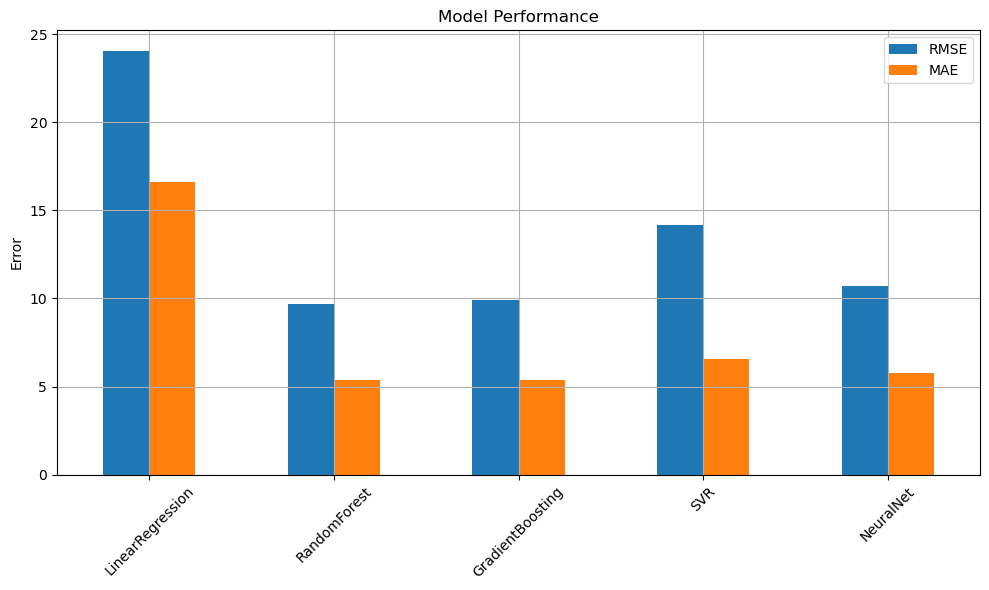

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame(results).T
print(results_df)

results_df[['RMSE', 'MAE']].plot(kind='bar', figsize=(10, 6), title='Model Performance')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1/200


c:\Users\dilip\anaconda3\envs\radarviz\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


487/487 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 423.2443 - mae: 12.2388 - val_loss: 144.7681 - val_mae: 6.4051 - learning_rate: 0.0100
Epoch 2/200
487/487 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 243.4124 - mae: 9.0922 - val_loss: 153.8722 - val_mae: 6.7930 - learning_rate: 0.0100
Epoch 3/200
487/487 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 205.5903 - mae: 8.3785 - val_loss: 184.4162 - val_mae: 7.9306 - learning_rate: 0.0100
Epoch 4/200
487/487 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 198.6991 - mae: 8.1452 - val_loss: 144.6416 - val_mae: 6.4968 - learning_rate: 0.0100
Epoch 5/200
487/487 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 192.2780 - mae: 8.0374 - val_loss: 158.8769 - val_mae: 7.1102 - learning_rate: 0.0100
Epoch 6/200
487/487 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 192.4182 - mae: 8.0696 - val_loss: 150.8653 - val_mae: 7.1480 - learning_rate: 0.0100
Epoch 7/200
487/487 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 175.8228 - mae: 7.9020 - val_loss: 152.5053 - val_mae: 7.1002 - lear

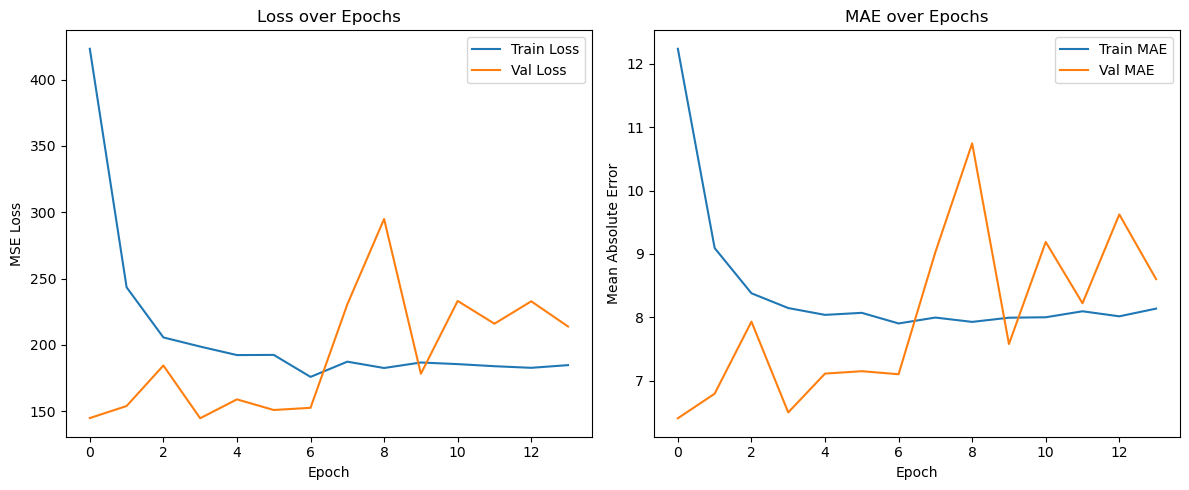

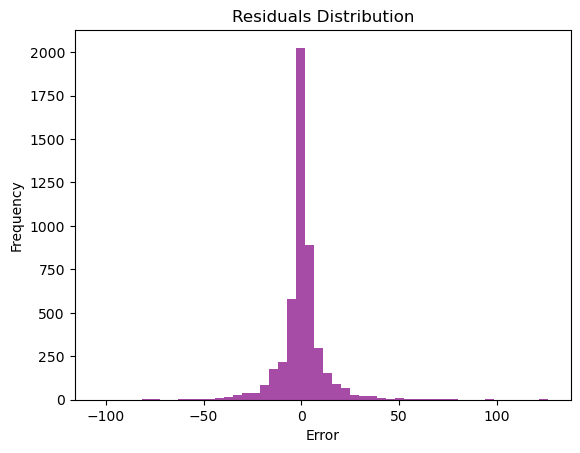

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Define model architecture
def build_nn_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=l2(0.001), input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(1)
    ])
    return model

# Compile model
nn_model = build_nn_model(X_train_scaled.shape[1])
nn_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

# Train model
history = nn_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, lr_schedule],
    verbose=1
)

# Predict and evaluate
y_pred_nn = nn_model.predict(X_test_scaled).flatten()
results['NeuralNet'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_nn)),
    'MAE': mean_absolute_error(y_test, y_pred_nn),
    'R2': r2_score(y_test, y_pred_nn)
}

# Print results
for metric, value in results['NeuralNet'].items():
    print(f"{metric}: {value:.4f}")

# Plot training loss and MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

# Plot residuals
residuals = y_test - y_pred_nn
plt.hist(residuals, bins=50, color='purple', alpha=0.7)
plt.title("Residuals Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

🔍 Random Forest Performance:
RMSE: 9.4896
MAE: 5.2359
R2: 0.9157


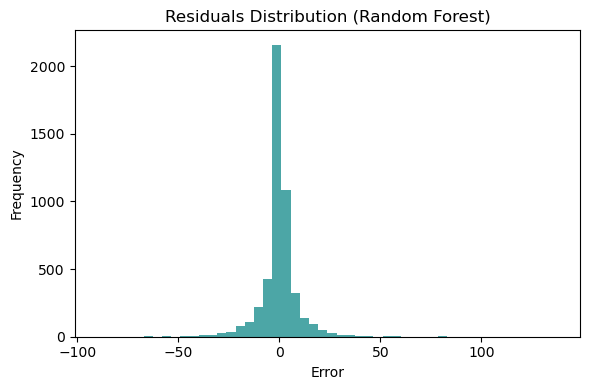

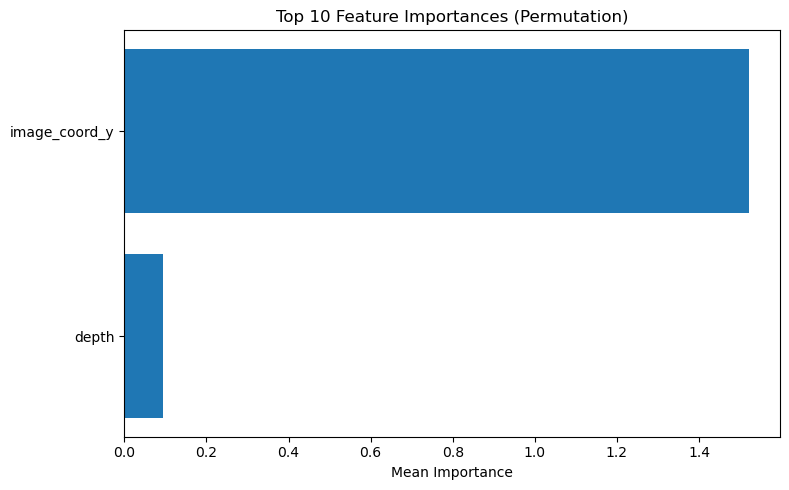

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# Step 1: Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_rf = grid_search.best_estimator_

# Step 2: Predict and evaluate
y_pred_rf = best_rf.predict(X_test_scaled)
results['RandomForest_Tuned'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'MAE': mean_absolute_error(y_test, y_pred_rf),
    'R2': r2_score(y_test, y_pred_rf)
}

# Print results
print("🔍 Random Forest Performance:")
for metric, value in results['RandomForest_Tuned'].items():
    print(f"{metric}: {value:.4f}")

# Step 3: Residual analysis
residuals = y_test - y_pred_rf
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=50, color='teal', alpha=0.7)
plt.title("Residuals Distribution (Random Forest)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Step 4: Permutation importance
perm_importance = permutation_importance(best_rf, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Plot top 10 features
sorted_idx = perm_importance.importances_mean.argsort()[::-1][:10]
plt.figure(figsize=(8, 5))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X_train.columns[i] for i in sorted_idx])
plt.xlabel("Mean Importance")
plt.title("Top 10 Feature Importances (Permutation)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [11]:
#selected features is based on the EDA
df_model_y = df_ref[['image_coord_x', 'depth', 
'radar_y']]

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_model_y[['image_coord_x', 'depth']]
y = df_model_y['radar_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR()
}

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

nn_model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1)
])

nn_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

y_pred_nn = nn_model.predict(X_test_scaled).flatten()
results['NeuralNet'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_nn)),
    'MAE': mean_absolute_error(y_test, y_pred_nn),
    'R2': r2_score(y_test, y_pred_nn)
}

c:\Users\dilip\anaconda3\envs\radarviz\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step


                       RMSE       MAE        R2
LinearRegression  11.276803  7.804319  0.667730
RandomForest       8.367668  5.386759  0.817052
GradientBoosting   8.355021  5.580124  0.817604
SVR                8.964654  5.366819  0.790016
NeuralNet          8.539894  5.662739  0.809443


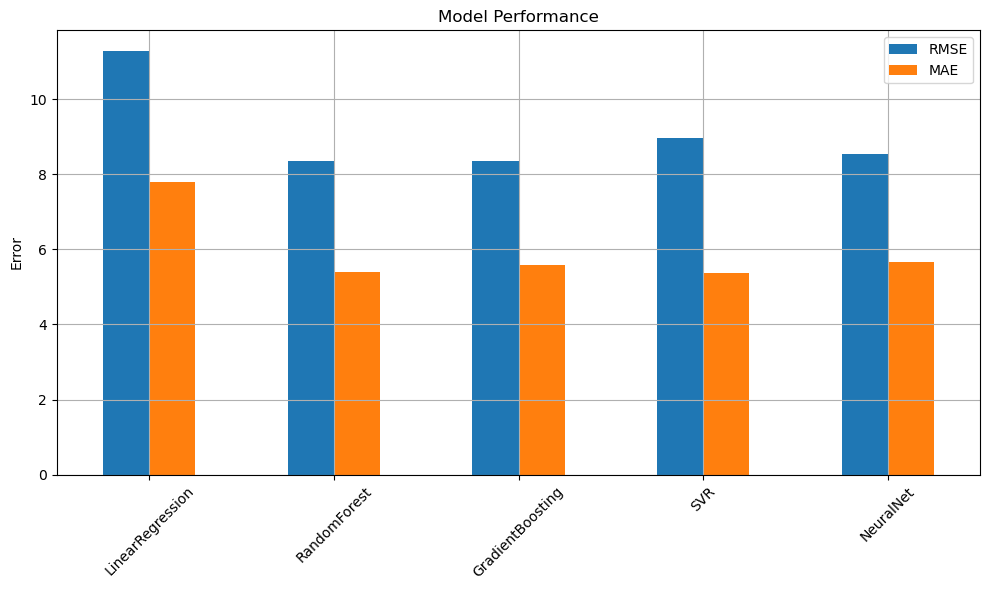

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame(results).T
print(results_df)

results_df[['RMSE', 'MAE']].plot(kind='bar', figsize=(10, 6), title='Model Performance')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

🔍 Random Forest Performance:
RMSE: 8.2109
MAE: 5.3895
R2: 0.8238


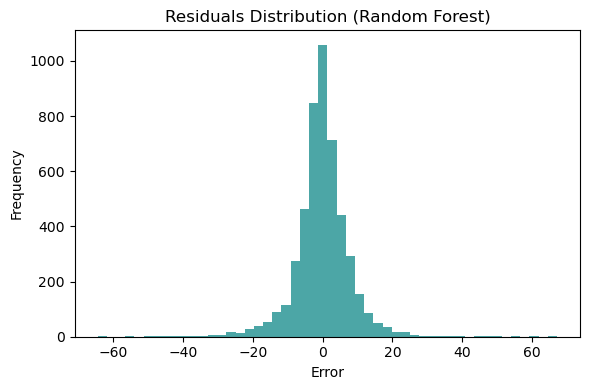

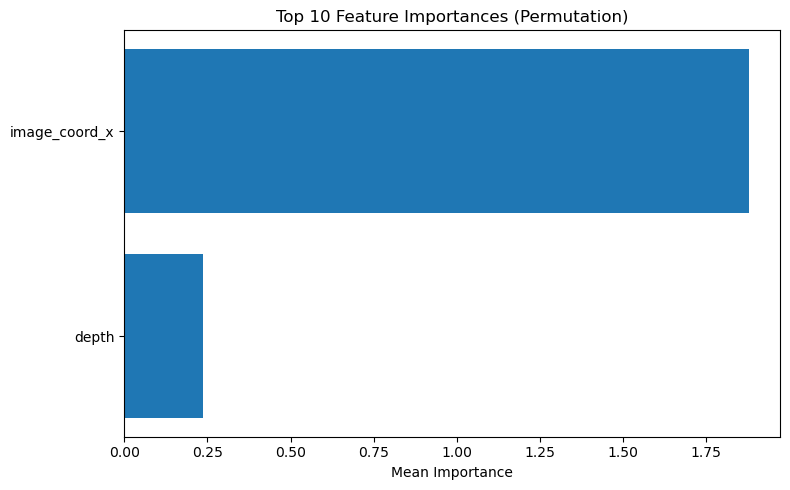

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# Step 1: Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_rf = grid_search.best_estimator_

# Step 2: Predict and evaluate
y_pred_rf = best_rf.predict(X_test_scaled)
results['RandomForest_Tuned'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'MAE': mean_absolute_error(y_test, y_pred_rf),
    'R2': r2_score(y_test, y_pred_rf)
}

# Print results
print("🔍 Random Forest Performance:")
for metric, value in results['RandomForest_Tuned'].items():
    print(f"{metric}: {value:.4f}")

# Step 3: Residual analysis
residuals = y_test - y_pred_rf
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=50, color='teal', alpha=0.7)
plt.title("Residuals Distribution (Random Forest)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Step 4: Permutation importance
perm_importance = permutation_importance(best_rf, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Plot top 10 features
sorted_idx = perm_importance.importances_mean.argsort()[::-1][:10]
plt.figure(figsize=(8, 5))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X_train.columns[i] for i in sorted_idx])
plt.xlabel("Mean Importance")
plt.title("Top 10 Feature Importances (Permutation)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()